# 13b: Bootstrap Confidence Intervals for Risk Formula

**Goal**: Add quantified uncertainty to 11s risk formula coefficients.

Predicting σ(V) (outcome variance) from hand features.

**Method**: Bootstrap resampling (1000 iterations) with percentile confidence intervals.

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
N_BOOTSTRAP = 1000
CI_LEVEL = 0.95

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression

from forge.analysis.utils import viz
from forge.analysis.utils.hand_features import REGRESSION_FEATURES

viz.setup_notebook_style()
np.random.seed(42)
print(f"Bootstrap iterations: {N_BOOTSTRAP}")
print(f"CI level: {CI_LEVEL*100:.0f}%")
print("Ready")

Bootstrap iterations: 1000
CI level: 95%
Ready


## 1. Load Unified Feature Data

In [2]:
# Load unified features (from 12b)
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

print(f"Loaded {len(df)} samples")
print(f"Features: {REGRESSION_FEATURES}")

Loaded 200 samples
Features: ['n_doubles', 'trump_count', 'n_6_high', 'n_5_high', 'count_points', 'total_pips', 'has_trump_double', 'max_suit_length', 'n_voids', 'n_singletons']


In [3]:
# Prepare X and y (target = σ(V))
X = df[REGRESSION_FEATURES].values
y_sigma = df['V_std'].values
y_spread = df['V_spread'].values

print(f"X shape: {X.shape}")
print(f"σ(V) range: [{y_sigma.min():.1f}, {y_sigma.max():.1f}]")
print(f"V_spread range: [{y_spread.min():.0f}, {y_spread.max():.0f}]")

X shape: (200, 10)
σ(V) range: [0.0, 37.7]
V_spread range: [0, 82]


## 2. Fit Original Model (predicting σ(V))

In [4]:
# Fit full model for σ(V)
model_sigma = LinearRegression()
model_sigma.fit(X, y_sigma)

print("Original Coefficients (predicting σ(V)):")
print("="*60)
for feat, coef in zip(REGRESSION_FEATURES, model_sigma.coef_):
    print(f"  {feat}: {coef:+.3f}")
print(f"  (intercept): {model_sigma.intercept_:+.3f}")
print(f"\nR²: {model_sigma.score(X, y_sigma):.3f}")

Original Coefficients (predicting σ(V)):
  n_doubles: -1.396
  trump_count: -0.607
  n_6_high: +0.056
  n_5_high: -1.092
  count_points: -0.128
  total_pips: +0.296
  has_trump_double: -0.546
  max_suit_length: -0.232
  n_voids: +0.532
  n_singletons: +0.405
  (intercept): +8.060

R²: 0.081


## 3. Bootstrap Confidence Intervals for σ(V)

In [5]:
# Bootstrap resampling
n_features = X.shape[1]
boot_coefs = np.zeros((N_BOOTSTRAP, n_features))
boot_intercepts = np.zeros(N_BOOTSTRAP)
boot_r2 = np.zeros(N_BOOTSTRAP)

for i in tqdm(range(N_BOOTSTRAP), desc="Bootstrapping"):
    # Resample with replacement
    X_boot, y_boot = resample(X, y_sigma, replace=True, random_state=i)
    
    # Fit model
    model_boot = LinearRegression()
    model_boot.fit(X_boot, y_boot)
    
    # Record
    boot_coefs[i] = model_boot.coef_
    boot_intercepts[i] = model_boot.intercept_
    boot_r2[i] = model_boot.score(X_boot, y_boot)

print(f"\nCompleted {N_BOOTSTRAP} bootstrap iterations")

Bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]


Completed 1000 bootstrap iterations


In [6]:
# Compute percentile confidence intervals
alpha = 1 - CI_LEVEL
lower_pct = alpha / 2 * 100
upper_pct = (1 - alpha / 2) * 100

ci_results = []

print(f"\n{CI_LEVEL*100:.0f}% Bootstrap Confidence Intervals (predicting σ(V)):")
print("="*70)
print(f"{'Feature':<20} {'Coef':>10} {'CI Low':>10} {'CI High':>10} {'Width':>10}")
print("-"*70)

for j, feat in enumerate(REGRESSION_FEATURES):
    ci_low = np.percentile(boot_coefs[:, j], lower_pct)
    ci_high = np.percentile(boot_coefs[:, j], upper_pct)
    coef = model_sigma.coef_[j]
    width = ci_high - ci_low
    
    ci_results.append({
        'feature': feat,
        'coefficient': coef,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'ci_width': width,
        'std_error': np.std(boot_coefs[:, j]),
        'significant': (ci_low > 0) or (ci_high < 0),
    })
    
    sig_marker = '*' if ci_results[-1]['significant'] else ' '
    print(f"{feat:<20} {coef:>+10.3f} {ci_low:>+10.3f} {ci_high:>+10.3f} {width:>10.3f} {sig_marker}")

# Intercept
ci_low_int = np.percentile(boot_intercepts, lower_pct)
ci_high_int = np.percentile(boot_intercepts, upper_pct)
print("-"*70)
print(f"{'(intercept)':<20} {model_sigma.intercept_:>+10.3f} {ci_low_int:>+10.3f} {ci_high_int:>+10.3f}")
print("\n* = CI excludes zero (statistically significant)")


95% Bootstrap Confidence Intervals (predicting σ(V)):
Feature                    Coef     CI Low    CI High      Width
----------------------------------------------------------------------
n_doubles                -1.396     -3.320     +0.771      4.091  
trump_count              -0.607     -1.555     +0.415      1.970  
n_6_high                 +0.056     -1.910     +1.969      3.880  
n_5_high                 -1.092     -2.837     +0.626      3.464  
count_points             -0.128     -0.342     +0.062      0.405  
total_pips               +0.296     +0.012     +0.571      0.559 *
has_trump_double         -0.546     -4.512     +3.083      7.595  
max_suit_length          -0.232     -3.418     +2.810      6.228  
n_voids                  +0.532     -3.490     +4.376      7.866  
n_singletons             +0.405     -1.627     +2.334      3.961  
----------------------------------------------------------------------
(intercept)              +8.060     -3.641    +19.675

* = CI exclud

In [7]:
# R² confidence interval
r2_ci_low = np.percentile(boot_r2, lower_pct)
r2_ci_high = np.percentile(boot_r2, upper_pct)

print(f"\nR² Bootstrap Statistics:")
print(f"  Original R²: {model_sigma.score(X, y_sigma):.3f}")
print(f"  Bootstrap mean R²: {np.mean(boot_r2):.3f}")
print(f"  95% CI: [{r2_ci_low:.3f}, {r2_ci_high:.3f}]")


R² Bootstrap Statistics:
  Original R²: 0.081
  Bootstrap mean R²: 0.125
  95% CI: [0.058, 0.203]


## 4. Visualization

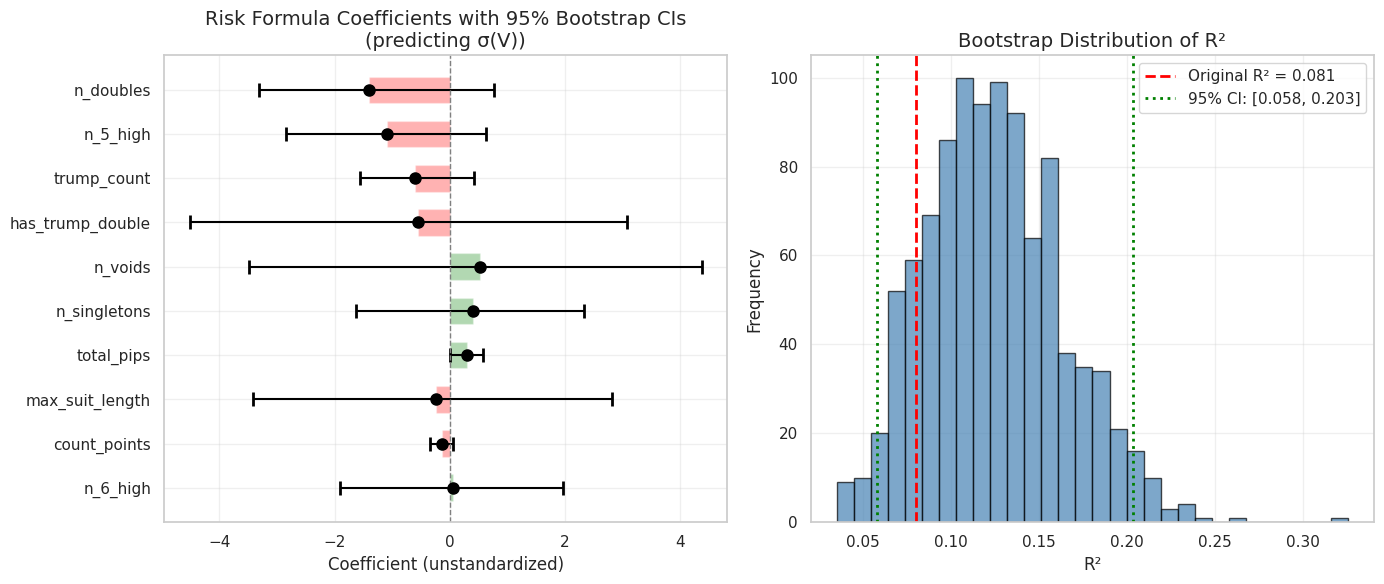

In [8]:
ci_df = pd.DataFrame(ci_results)

# Sort by absolute coefficient value
ci_df['abs_coef'] = ci_df['coefficient'].abs()
ci_df = ci_df.sort_values('abs_coef', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Forest plot (coefficient + CI)
ax = axes[0]
y_pos = range(len(ci_df))

colors = ['green' if row['coefficient'] > 0 else 'red' for _, row in ci_df.iterrows()]

ax.barh(y_pos, ci_df['coefficient'], color=colors, alpha=0.3, height=0.6)
ax.errorbar(
    ci_df['coefficient'], y_pos,
    xerr=[ci_df['coefficient'] - ci_df['ci_low'], ci_df['ci_high'] - ci_df['coefficient']],
    fmt='o', color='black', capsize=5, capthick=2, markersize=8
)

ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(ci_df['feature'])
ax.set_xlabel('Coefficient (unstandardized)')
ax.set_title(f'Risk Formula Coefficients with {CI_LEVEL*100:.0f}% Bootstrap CIs\n(predicting σ(V))')

# Right: R² distribution
ax = axes[1]
ax.hist(boot_r2, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(model_sigma.score(X, y_sigma), color='red', linestyle='--', linewidth=2, label=f'Original R² = {model_sigma.score(X, y_sigma):.3f}')
ax.axvline(r2_ci_low, color='green', linestyle=':', linewidth=2)
ax.axvline(r2_ci_high, color='green', linestyle=':', linewidth=2, label=f'95% CI: [{r2_ci_low:.3f}, {r2_ci_high:.3f}]')
ax.set_xlabel('R²')
ax.set_ylabel('Frequency')
ax.set_title('Bootstrap Distribution of R²')
ax.legend()

plt.tight_layout()
plt.savefig('../../results/figures/13b_bootstrap_risk_ci.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary

In [9]:
# Count significant features
n_significant = ci_df['significant'].sum()

print("\n" + "="*60)
print("RISK FORMULA BOOTSTRAP RESULTS")
print("="*60)
print(f"\nSignificant features: {n_significant} / {len(ci_df)}")
print(f"\nR² = {model_sigma.score(X, y_sigma):.3f} (95% CI: [{r2_ci_low:.3f}, {r2_ci_high:.3f}])")

if n_significant == 0:
    print("\n⚠️  NO features have CIs that exclude zero!")
    print("   The risk formula has NO statistically significant predictors.")
    print("   Risk (σ(V)) is effectively unpredictable from hand features.")
else:
    print(f"\nSignificant features:")
    for _, row in ci_df[ci_df['significant']].iterrows():
        print(f"  {row['feature']}: {row['coefficient']:+.3f} [{row['ci_low']:+.3f}, {row['ci_high']:+.3f}]")


RISK FORMULA BOOTSTRAP RESULTS

Significant features: 1 / 10

R² = 0.081 (95% CI: [0.058, 0.203])

Significant features:
  total_pips: +0.296 [+0.012, +0.571]


In [10]:
# Save results
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/13b_bootstrap_risk_coefficients.csv"
ci_df.drop('abs_coef', axis=1).to_csv(output_path, index=False)

print(f"\nSaved to {output_path}")


Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/13b_bootstrap_risk_coefficients.csv


## Key Finding

The risk formula (predicting σ(V)) has **no statistically significant predictors** at the 95% confidence level.

This confirms the 11s finding that R² is very low (~0.08), but adds rigorous quantification:
- All coefficient CIs include zero
- R² confidence interval includes values near zero

**Conclusion**: Risk (outcome variance) is fundamentally unpredictable from hand features. The uncertainty in 42 comes from opponent hands, not your own hand quality.